In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Ensures plots are displayed within the notebook
%matplotlib inline


In [6]:
def plot_function(func, xmin=-5, xmax=5, num_points=1000):
    """
    Plots a given function 'func' over the range [xmin, xmax].
    
    Parameters:
    func (function): The function to plot.
    xmin (float): The minimum value of x (default: -5).
    xmax (float): The maximum value of x (default: +5).
    num_points (int): Number of points to generate between xmin and xmax (default: 1000).
    """
    
    # Generate x values
    x_values = np.linspace(xmin, xmax, num_points)
    
    # Compute corresponding y values by applying the function to each x
    y_values = func(x_values)
    
    # Plot the function
    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, label=f'Function: {func.__name__}')
    # plt.title(f'Plot of {func.__name__}')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.grid(True)
    # plt.legend()
    plt.show()

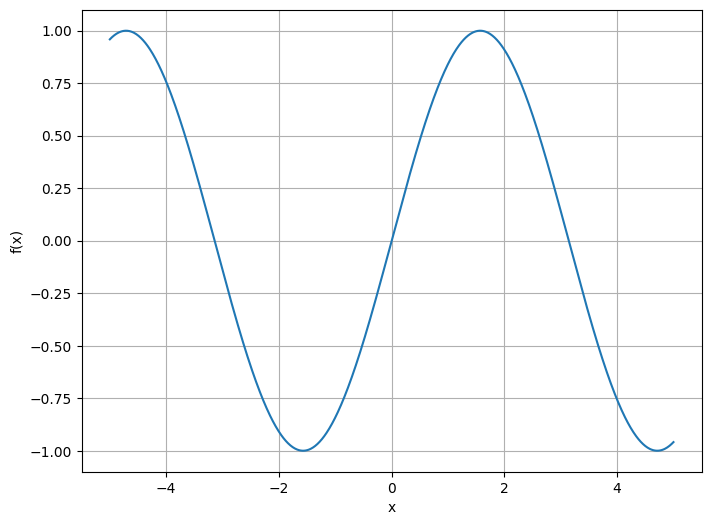

In [7]:
plot_function(np.sin)

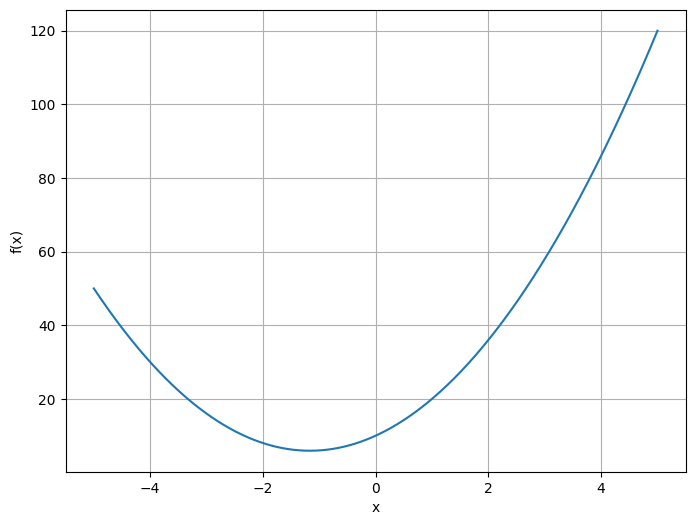

In [8]:
plot_function(lambda x: 3*x**2 + 7*x + 10)

# Micrograd building blocks

Building micrograd requires the follows:
- A `Value` class which handles individual numeric values.
- A `Neuron` class which handles an individual Neuron in the MLP
- A `Layer` class which handles an array of neurons
- A `MLP` class which handles the full MLP which is a concatenation of many `Layer` objects. 

## `Value` class

In [58]:
class Value:
    def __init__(self, value, pred=(), op=''):
        self.value = value
        self._pred = pred
        self._op = op
        
    def __repr__(self):
        return f"Value: {self.value:.4f}"
        
    def __add__(self, other):
        # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Add the values
        res = self.value + other.value
        return Value(res, pred = (self, other), op = '+')

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
         # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Sub the values
        res = self+ -1*other
        return res

    def __rsub__(self, other):
         return -1*(self-other)

    def __mul__(self, other):
        # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Mult the values
        res = self.value * other.value
        return Value(res, pred = (self, other), op = '*')

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # we want the power to be an integer/float
        res = self.value**other
        return Value(res, pred = (self,), op = f'**{other}')

    def __truediv__(self, other):
         # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # Divide the values
        assert other.value != 0.0
        res = self.value * other.value**(-1)
        return Value(res, pred = (self, other), op = '/')

    def __rtruediv__(self, other):
        # handle cases where the other can be sinple float or integer
        other = Value(other) if isinstance(other, int) or isinstance(other, float) else other
        # now check add another condition if other.value is 0, otherwise reciprocal will throw error
        if other.value==0:
            return Value(0, pred = (other, self), op='/')
        return (self / other)**(-1)

In [59]:
a = Value(1)
b = Value(2.5)
c = Value(1.4)

In [66]:
d = Value(1e6)
d/1e-6

Value: 1000000000000.0000

In [67]:
1e6/1e-6

1000000000000.0

## Graph visualisation

In [68]:
!pip install graphviz

In [72]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._pred:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ value %.4f }" % (n.value), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [73]:
d = a + b
e = d * c
f = e * 2 + d / 3
draw_dot(f)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH